# NAME : PATEL CHINTAN DAHYALAL

## TOPIC : FACIES IDENTIFICATION USING MACHINE LEARNING

### M.TECH THESIS PART 1

## Step 01 Importing Relevent Library : 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
#from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
#import pydotplus
import pickle

In [2]:
raw_data = pd.read_csv("train.csv")

In [3]:
raw_data.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


In [4]:
print(raw_data.shape)

(4149, 11)


In [5]:
pd.DataFrame(raw_data.dtypes).T

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,int64,object,object,float64,float64,float64,float64,float64,float64,int64,float64


##### Remove a single well to use as a blind test later.

In [6]:
blind = raw_data[raw_data['Well Name'] == 'SHANKLE']
raw_data = raw_data[raw_data['Well Name'] != 'SHANKLE']
print(raw_data.shape)

(3700, 11)


## Step 02 : Lets clean up dataset to use

In [7]:
raw_data['Well Name'] = raw_data['Well Name'].astype('category')
raw_data['Formation'] = raw_data['Formation'].astype('category')


In [8]:
#check unique category present inside well name
raw_data['Well Name'].unique()

['SHRIMPLIN', 'ALEXANDER D', 'LUKE G U', 'KIMZEY A', 'CROSS H CATTLE', 'NOLAN', 'Recruit F9', 'NEWBY', 'CHURCHMAN BIBLE']
Categories (9, object): ['SHRIMPLIN', 'ALEXANDER D', 'LUKE G U', 'KIMZEY A', ..., 'NOLAN', 'Recruit F9', 'NEWBY', 'CHURCHMAN BIBLE']

In [9]:
raw_data["Formation"].unique()

['A1 SH', 'A1 LM', 'B1 SH', 'B1 LM', 'B2 SH', ..., 'B4 LM', 'B5 SH', 'B5 LM', 'C SH', 'C LM']
Length: 14
Categories (14, object): ['A1 SH', 'A1 LM', 'B1 SH', 'B1 LM', ..., 'B5 SH', 'B5 LM', 'C SH', 'C LM']

In [10]:
# 1=sandstone  2=c_siltstone (c means course)   3=f_siltstone (f means fines)
# 4=marine_silt_shale 5=mudstone(lm) 6=wackestone(lm) 7=dolomite
# 8=packstone(lm) 9=bafflestone(lm)

#following code is hexacode for colour arguments
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

#Abreviation for different facies are following and it is in order of above list
facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']

In [11]:
#facies_color_map is a dictionary that maps facies labels to their respective colors
#enumerate is making truple for iteration and labes 
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

In [12]:
#it will use to provide colour argument in graphs to provide colour to facies
facies_color_map

{'SS': '#F4D03F',
 'CSiS': '#F5B041',
 'FSiS': '#DC7633',
 'SiSh': '#6E2C00',
 'MS': '#1B4F72',
 'WS': '#2E86C1',
 'D': '#AED6F1',
 'PS': '#A569BD',
 'BS': '#196F3D'}

In [13]:
raw_data["Facies"].unique()

array([3, 2, 8, 6, 7, 4, 5, 9, 1], dtype=int64)

In [14]:
#adding facies_lable to training dataset 
#As index starts with zero hence row["Facies"] indicate number of element in facies_label which actually has index one less
def label_facies(row, labels):
    return labels[ row['Facies'] -1]

In [15]:
raw_data.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


In [16]:
#apply function applied to axis = 1 means to particular columns or row wise
#row == training_data
#facies_label already listed in list
#facies_label[ row["facies"] - 1]
         #above term indicate index  #select element of that index from facies_label
#minus one is for python index starts from zero and facies number from 1 to 9
raw_data.loc[:,'FaciesLabels'] = raw_data.apply(lambda row: label_facies(row, facies_labels), axis=1)


In [17]:
raw_data.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesLabels
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000,FSiS
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979,FSiS
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957,FSiS
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936,FSiS
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915,FSiS


In [18]:
raw_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3700.000000,3700.000000,3700.000000,3700.000000,3700.000000,3700.000000,2783.000000,3700.000000,3700.000000
mean,4.615676,2908.853378,64.873649,0.663053,4.651677,12.892826,3.805693,1.540000,0.524125
std,2.475808,139.010855,30.817166,0.253863,5.109006,6.796219,0.894118,0.498465,0.287147
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2818.500000,43.778250,0.502000,1.800000,8.350000,3.200000,1.000000,0.278000
50%,4.000000,2939.000000,64.817000,0.645613,4.400000,11.857500,3.600000,2.000000,0.531000
75%,7.000000,3015.125000,80.322500,0.823000,7.600000,15.750000,4.400000,2.000000,0.772000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


In [19]:
training_data = raw_data.copy()

In [20]:
#Cheking null values
training_data.isnull().sum()

Facies            0
Formation         0
Well Name         0
Depth             0
GR                0
ILD_log10         0
DeltaPHI          0
PHIND             0
PE              917
NM_M              0
RELPOS            0
FaciesLabels      0
dtype: int64

<AxesSubplot:>

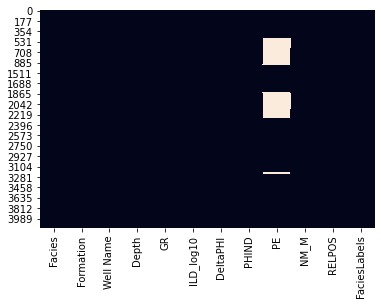

In [21]:
sns.heatmap(training_data.isnull() , cbar=False)

## Step 03 : Exploratory Data Analysis .....

Generating Synthesis PE data using machine learning algorithm because PE is crucial to identify facies records and removing data may cause loss of certain facies records as well as compromization with accuracy.

In [22]:
training_data.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesLabels
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000,FSiS
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979,FSiS
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957,FSiS
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936,FSiS
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915,FSiS


In [23]:
training_data.corr()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
Facies,1.000000,0.304678,-0.404602,0.358038,-0.281287,-0.354580,0.705426,0.844671,0.075373
Depth,0.304678,1.000000,-0.092631,0.207440,0.075326,-0.100950,0.309627,0.280202,0.007688
GR,-0.404602,-0.092631,1.000000,-0.223036,0.197810,0.292074,-0.323830,-0.328419,-0.178793
ILD_log10,0.358038,0.207440,-0.223036,1.000000,-0.124253,-0.552354,0.348371,0.479648,0.098061
DeltaPHI,-0.281287,0.075326,0.197810,-0.124253,1.000000,-0.111885,-0.042708,-0.232377,0.006007
PHIND,-0.354580,-0.100950,0.292074,-0.552354,-0.111885,1.000000,-0.545571,-0.474921,-0.026079
PE,0.705426,0.309627,-0.323830,0.348371,-0.042708,-0.545571,1.000000,0.646854,0.014080
NM_M,0.844671,0.280202,-0.328419,0.479648,-0.232377,-0.474921,0.646854,1.000000,0.035504
RELPOS,0.075373,0.007688,-0.178793,0.098061,0.006007,-0.026079,0.014080,0.035504,1.000000


<AxesSubplot:>

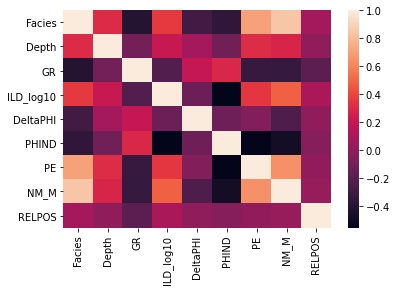

In [24]:
sns.heatmap(training_data.corr())

1. there is no relation between DeltaPhi and RELPOS columns of PE.
2. However Depth , RELPOS is not importanat for Prediction of PE columns.
3. Form Liturature it evidended that random forest shown good test accuracy for dataset hence here Random forest is applied to predict synthesised PE values 

In [25]:
training_data.dropna(inplace = True)

## Step 04 : Modelling For PE values to replace synthesis PE data

In [26]:
x = training_data.drop(["Depth" , "DeltaPHI" , "FaciesLabels" ,"Formation" ,"RELPOS" , "PE" , "Well Name"] , axis = 1)
y = training_data.PE


In [27]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [28]:
from sklearn.model_selection import train_test_split,GridSearchCV
x_train,x_test,y_train,y_test = train_test_split(x_scaled,y,test_size = 0.20, random_state= 42)

In [29]:
from sklearn.ensemble import RandomForestClassifier , RandomForestRegressor


In [30]:
rand_clf = RandomForestRegressor(random_state=6 )
rand_clf.fit(x_train,y_train)

RandomForestRegressor(random_state=6)

In [31]:
rand_clf.score(x_train,y_train)

0.9651994436204674

In [32]:
rand_clf.score(x_test,y_test)

0.745931827916815

In [33]:
# we are tuning three hyperparameters right now, we are passing the different values for both parameters
grid_param = {
    "n_estimators" : [70,150,200],
    'criterion': ['mse', 'mae'],
    'max_depth' : range(2,20,4),
    'min_samples_leaf' : range(1,10,4),
    'min_samples_split': range(2,10,4),
    'max_features' : ['auto','log2']
}

In [34]:
#grid_search = GridSearchCV(estimator=rand_clf,param_grid=grid_param,cv=5,n_jobs =-1,verbose = 3)

In [35]:
y_train.isnull().sum()

0

In [36]:
#grid_search.fit(x_train,y_train)

In [37]:
#grid_search.best_params_

In [38]:
rand_clf = RandomForestRegressor(random_state=6 ,criterion = 'mae',max_depth= 18,max_features= 'log2',
                min_samples_leaf = 1,min_samples_split= 2, n_estimators= 200)
rand_clf.fit(x_train,y_train)

RandomForestRegressor(criterion='mae', max_depth=18, max_features='log2',
                      n_estimators=200, random_state=6)

In [39]:
rand_clf.score(x_test,y_test)

0.7519418805296055

In [40]:
y_predict = rand_clf.predict(x_test)

In [41]:
Result = pd.DataFrame()
Result["PE_actual"] = y_test
Result["PE_Predict"] = y_predict
Result["PE_Residue"] = abs(Result["PE_actual"] - Result["PE_Predict"])
Result["PE_difference%"] = Result["PE_Residue"] / Result["PE_actual"]

In [42]:
Result.sort_values("PE_difference%")

,PE_actual,PE_Predict,PE_Residue,PE_difference%
457,5.300,5.299900,0.000100,0.000019
252,3.000,3.000612,0.000612,0.000204
3270,4.926,4.928313,0.002313,0.000469
2619,2.877,2.879517,0.002517,0.000875
2513,3.553,3.556130,0.003130,0.000881
...,...,...,...,...
3941,2.760,3.844490,1.084490,0.392931
4129,3.422,4.776847,1.354847,0.395923
3872,1.968,3.021735,1.053735,0.535434
2698,0.646,1.675748,1.029748,1.594036


In [43]:
Result.describe()

,PE_actual,PE_Predict,PE_Residue,PE_difference%
count,557.000000,557.000000,557.000000,557.000000
mean,3.799569,3.795763,0.323845,0.109335
std,0.908487,0.743653,0.315706,0.554932
min,0.200000,1.675748,0.000100,0.000019
25%,3.200000,3.281520,0.107818,0.029792
50%,3.600000,3.624913,0.239155,0.065578
75%,4.500000,4.297812,0.454240,0.122705
max,6.902000,6.827835,2.596120,12.980600


C:\Users\CHINTAN PATEL\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\CHINTAN PATEL\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='PE_actual', ylabel='PE_Predict'>

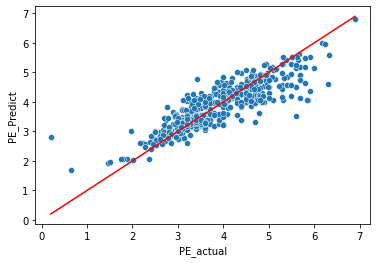

In [44]:
sns.scatterplot(Result["PE_actual"] ,Result["PE_Predict"] )
sns.lineplot(Result["PE_actual"] ,Result["PE_actual"] , color = "red")


In [45]:
#Lets create model file which used to predict PE on null values
pickle.dump(rand_clf,open("PE_random_forest.sav" , "wb"))

In [46]:
data_prediction = raw_data.copy()

In [47]:
data_prediction.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesLabels
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000,FSiS
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979,FSiS
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957,FSiS
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936,FSiS
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915,FSiS


In [48]:
x_predict = data_prediction[x.columns]

In [49]:
x_predict

,Facies,GR,ILD_log10,PHIND,NM_M
0,3,77.450,0.664,11.915,1
1,3,78.260,0.661,12.565,1
2,3,79.050,0.658,13.050,1
3,3,86.100,0.655,13.115,1
4,3,74.580,0.647,13.300,1
...,...,...,...,...,...
4144,5,46.719,0.947,7.254,2
4145,5,44.563,0.953,8.013,2
4146,5,49.719,0.964,8.013,2
4147,5,51.469,0.965,7.708,2


In [50]:
model = pickle.load(open("PE_random_forest.sav" , "rb"))

In [51]:
x_predict_scaled = scaler.transform(x_predict)

In [52]:
data_prediction["Synthesis_PE"] = model.predict(x_predict_scaled)

In [53]:
data_prediction

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesLabels,Synthesis_PE
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000,FSiS,3.709507
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979,FSiS,3.624840
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957,FSiS,3.507847
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936,FSiS,3.450567
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915,FSiS,3.462052
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685,MS,4.118425
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677,MS,3.681368
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669,MS,3.683083
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661,MS,3.671088


In [54]:
data_prediction["PE"] = np.where(data_prediction["PE"].isnull() == True,data_prediction["Synthesis_PE"],data_prediction["PE"] )

In [55]:
data_prediction

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesLabels,Synthesis_PE
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000,FSiS,3.709507
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979,FSiS,3.624840
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957,FSiS,3.507847
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936,FSiS,3.450567
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915,FSiS,3.462052
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685,MS,4.118425
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677,MS,3.681368
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669,MS,3.683083
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661,MS,3.671088


In [56]:
np.where(data_prediction["PE"] == 0)

(array([], dtype=int64),)

In [57]:
data_prediction.isnull().sum()

Facies          0
Formation       0
Well Name       0
Depth           0
GR              0
ILD_log10       0
DeltaPHI        0
PHIND           0
PE              0
NM_M            0
RELPOS          0
FaciesLabels    0
Synthesis_PE    0
dtype: int64

In [58]:
data_final = data_prediction.copy()

## Step 05 : Vizulization of Dataset

In [59]:
training_data = data_final.drop("Synthesis_PE" , axis = 1)

1. Function for plot vizulization

In [60]:
#logs is data for particular well to present inside graph
#facies_colors is dictionary for color argument for different facies
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth for only particular depth to get actual visulization
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    #values will take all values present inside facies 
    #here expand_dims changes dimention of array taken from values
    #axis = 1 means columns = 1 or add each component in new raw (n,1)
    #repeat will repeat argument of each rows element and repeat it 100 times and axis = 1 means 
    #increase it columnwise hence again dimention of arry changes (n,100) 100 element added to each rows
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,axis = 1), 100, 1)
    
    #following line is fix graphs in 6 columns
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    #following five graphs directly log vs depths
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    
    #following line of code is used for cluster map based on number argument
    #whereever 3 means indicating one facing and color argument is based on facies_color list pssed in cmap_facies
    #vmin = 1 and vmax = 9 indicate max and minimum values
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    #following lines of code is to set color bar map at right of last graphs
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    #set label as gievn in list and make 17 spaces between them..remember join add component to component .....
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    #setting labels and limits to dataset on x axis
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    #following is set common label to all and list is empty means it takes y axis values such as depth 
    #Else at every depth legends can be defined by passing set_ytick .............
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    
    #following is subplot commmon title for all wells
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)               
                   
                   

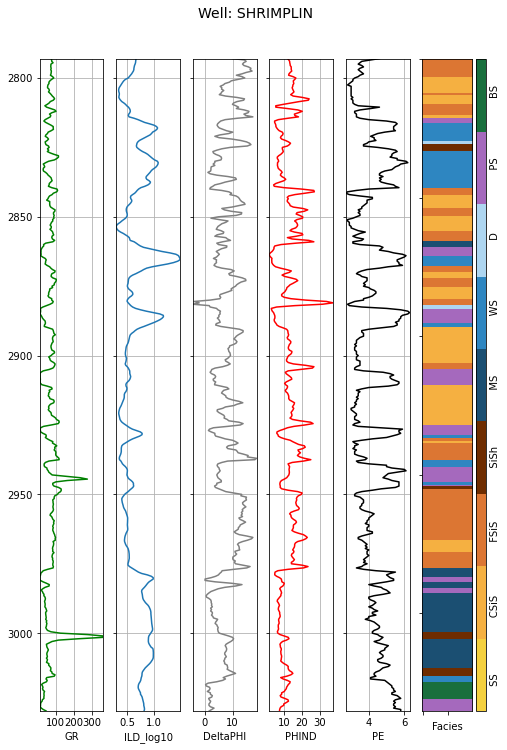

In [61]:
make_facies_log_plot(
    training_data[training_data['Well Name'] == 'SHRIMPLIN'],
    facies_colors)

1    179
2    851
3    663
4    264
5    277
6    511
7    124
8    646
9    185
Name: Facies, dtype: int64

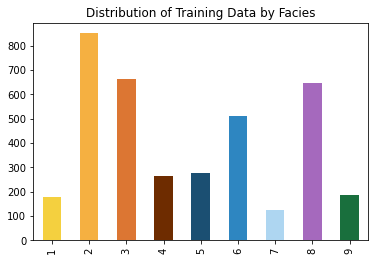

In [62]:
#count the number of unique entries for each facies, 
#facies number (instead of by number of entries)
facies_counts = training_data['Facies'].value_counts().sort_index()

facies_counts.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Training Data by Facies')
facies_counts

In [63]:
#use facies labels to index each count
facies_counts.index = facies_labels
facies_counts.sum()

3700

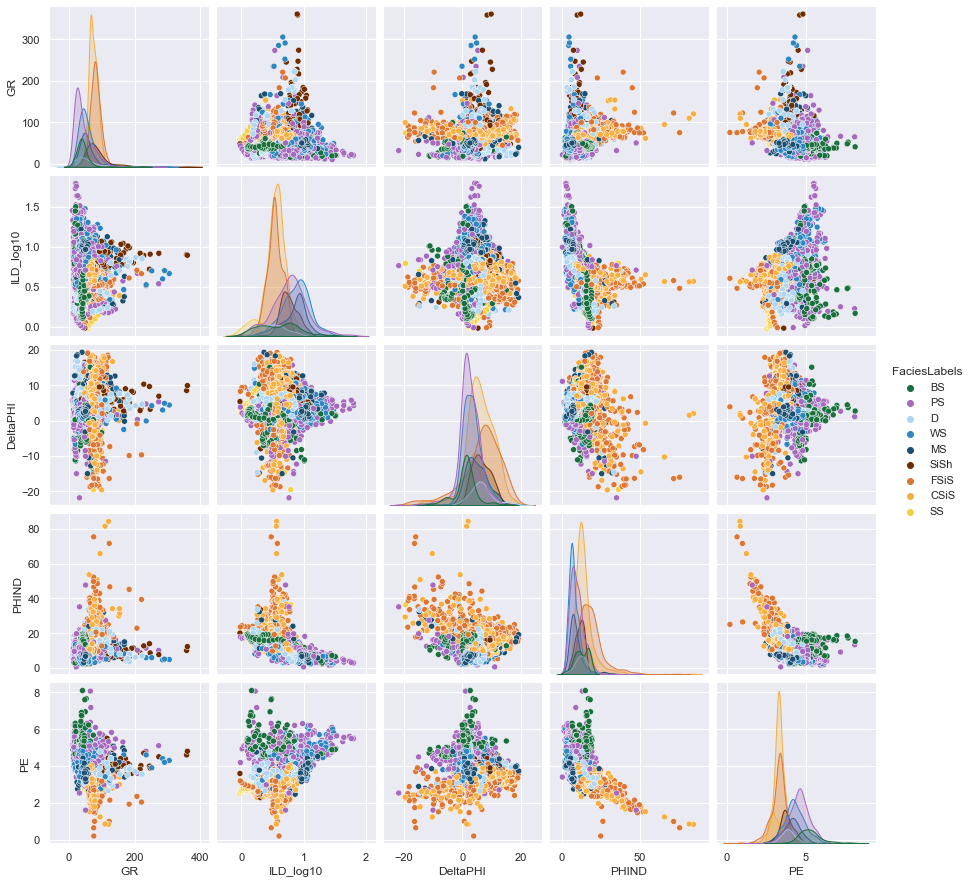

In [64]:
import seaborn as sns
sns.set()
sns.pairplot(training_data.drop(['Well Name','Facies','Formation','Depth','NM_M','RELPOS'],axis=1),
             hue='FaciesLabels', palette=facies_color_map,
             hue_order=list(reversed(facies_labels)))

## Step 06 : Feature Selection Engineering

In [65]:
correct_facies_labels = training_data['Facies'].values
correct_facies_labels

array([3, 3, 3, ..., 5, 5, 5], dtype=int64)

In [66]:
#Drop columns which are not important for classification problem such as depth , facies, facieslable , well name etc
feature_vectors = training_data.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
feature_vectors.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3700.000000,3700.000000,3700.000000,3700.000000,3700.000000,3700.000000,3700.000000
mean,64.873649,0.663053,4.651677,12.892826,3.831143,1.540000,0.524125
std,30.817166,0.253863,5.109006,6.796219,0.836958,0.498465,0.287147
min,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,43.778250,0.502000,1.800000,8.350000,3.253447,1.000000,0.278000
50%,64.817000,0.645613,4.400000,11.857500,3.683500,2.000000,0.531000
75%,80.322500,0.823000,7.600000,15.750000,4.389346,2.000000,0.772000
max,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


## Step 07 : scalling dataset

In [67]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)

In [68]:
scaled_features

array([[ 0.40815079,  0.00373176,  1.0274077 , ...,  0.91875673,
        -1.08347268,  1.65747441],
       [ 0.43443839, -0.00808722,  1.86917242, ...,  0.32127435,
        -1.08347268,  1.58433136],
       [ 0.46007692, -0.0199062 ,  1.98662796, ..., -0.27620804,
        -1.08347268,  1.50770529],
       ...,
       [-0.49182645,  1.18562983, -0.33801298, ..., -0.76614359,
         0.92295821,  0.5046005 ],
       [-0.43503224,  1.18956949, -0.30708302, ..., -0.81155225,
         0.92295821,  0.47673647],
       [-0.48170086,  1.2092678 , -0.3998729 , ..., -0.64067229,
         0.92295821,  0.44887245]])

## Step 08 : Splitting dataset for validation

In [69]:
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
        scaled_features, correct_facies_labels, test_size=0.2, random_state=42)

## Step 09 : Algorithm 01 : Support Vector Machine

In [70]:
from sklearn import svm

model01_svm_clf = svm.SVC()

In [71]:
#Now we can train the classifier using the training set we created above.
model01_svm_clf.fit(X_train,y_train)

SVC()

In [72]:
model01_predicted_labels = model01_svm_clf.predict(X_test)

## Step 10 : Evaluation of model

We need some metrics to evaluate how good our classifier is doing. A confusion matrix is a table that can be used to describe the performance of a classification model. Scikit-learn allows us to easily create a confusion matrix by supplying the actual and predicted facies labels.

The confusion matrix is simply a 2D array. The entries of confusion matrix C[i][j] are equal to the number of observations predicted to have facies j, but are known to have facies i.

To simplify reading the confusion matrix, a function has been written to display the matrix along with facies labels and various error metrics. See the file classification_utilities.py in this repo for the display_cm() function.

1. function for confusion matrix which takes two argument one is inbuilt confusion matrix and second one is facies_labels already discribed earlier

In [73]:
def display_cm(cm, labels, hide_zeros=False,
                             display_metrics=False):
    """Display confusion matrix with labels, along with
       metrics such as Recall, Precision and F1 score.
       Based on Zach Guo's print_cm gist at
       https://gist.github.com/zachguo/10296432
    """
   #Precision is facies predicted / total predicted...actual predicted sst out of actual sst present 
    precision = np.diagonal(cm)/cm.sum(axis=0).astype('float')
    #Recall is actual / no of times predicted that facies....actual predicted sst out of predicted sst
    recall = np.diagonal(cm)/cm.sum(axis=1).astype('float')
    F1 = 2 * (precision * recall) / (precision + recall)
    
    precision[np.isnan(precision)] = 0
    recall[np.isnan(recall)] = 0
    F1[np.isnan(F1)] = 0
    
    total_precision = np.sum(precision * cm.sum(axis=1)) / cm.sum(axis=(0,1))
    total_recall = np.sum(recall * cm.sum(axis=1)) / cm.sum(axis=(0,1))
    total_F1 = np.sum(F1 * cm.sum(axis=1)) / cm.sum(axis=(0,1))
    #print total_precision
    
    columnwidth = max([len(x) for x in labels]+[5]) # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + " Pred", end=' ')
    for label in labels: 
        print("%{0}s".format(columnwidth) % label, end=' ')
    print("%{0}s".format(columnwidth) % 'Total')
    print("    " + " True")
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=' ')
        for j in range(len(labels)): 
            cell = "%{0}d".format(columnwidth) % cm[i, j]
            if hide_zeros:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            print(cell, end=' ')
        print("%{0}d".format(columnwidth) % sum(cm[i,:]))
        
    if display_metrics:
        print()
        print("Precision", end=' ')
        for j in range(len(labels)):
            cell = "%{0}.2f".format(columnwidth) % precision[j]
            print(cell, end=' ')
        print("%{0}.2f".format(columnwidth) % total_precision)
        print("   Recall", end=' ')
        for j in range(len(labels)):
            cell = "%{0}.2f".format(columnwidth) % recall[j]
            print(cell, end=' ')
        print("%{0}.2f".format(columnwidth) % total_recall)
        print("       F1", end=' ')
        for j in range(len(labels)):
            cell = "%{0}.2f".format(columnwidth) % F1[j]
            print(cell, end=' ')
        print("%{0}.2f".format(columnwidth) % total_F1)
        
    print(" "*5,"Total F1 Score for method : {}".format(total_F1))

2. following function again takes simmilar fisrt two argument where adjusted_facies argument is discribed further as same name

In [74]:
def display_adj_cm(
        cm, labels, adjacent_facies, hide_zeros=False, 
        display_metrics=False):
    """This function displays a confusion matrix that counts 
       adjacent facies as correct.
    """
    adj_cm = np.copy(cm)
    
    for i in np.arange(0,cm.shape[0]):
        for j in adjacent_facies[i]:
            adj_cm[i][i] += adj_cm[i][j]
            adj_cm[i][j] = 0.0
        
    display_cm(adj_cm, labels, hide_zeros, 
                             display_metrics)

In [75]:
from sklearn.metrics import confusion_matrix
#from classification_utilities import display_cm, display_adj_cm

conf = confusion_matrix(y_test, model01_predicted_labels)
display_cm(conf, facies_labels, hide_zeros=True)


     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    16    26     2                                        44
     CSiS         150    27                                       177
     FSiS          45    84           1     1           1         132
     SiSh                 1    50          12           1          64
       MS           2           6     4    27           6          45
       WS                      12     4    55     2    23     1    97
        D                             1     1    12    14          28
       PS                 2     6     2    29     1    74     4   118
       BS                                         2    15    18    35
      Total F1 Score for method : 0.6112847894625427


#The rows of the confusion matrix correspond to the actual facies labels. The columns correspond to the labels assigned by the classifier. For example, consider the first row. For the feature vectors in the test set that actually have label SS, 19 were correctly indentified as SS, 19 were classified as CSiS and 1 were classified as FSiS.

The entries along the diagonal are the facies that have been correctly classified. Below we define two functions that will give an overall value for how the algorithm is performing. The accuracy is defined as the number of correct classifications divided by the total number of classifications.

3. Following function is for accuracy prediction which takes confusion matrix as arguments

In [76]:
 def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

In [77]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])
def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

## Step 11 : SVM Model Parameter Selection


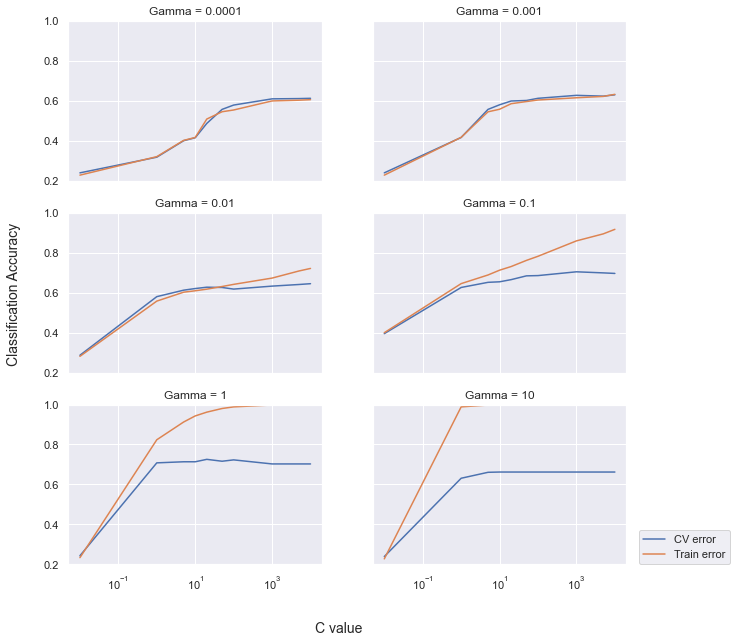

In [78]:
#to true to run the parameter loop
do_model_selection = True

if do_model_selection:
    C_range = np.array([.01, 1, 5, 10, 20, 50, 100, 1000, 5000, 10000])
    gamma_range = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10])
    
    fig, axes = plt.subplots(3, 2, 
                        sharex='col', sharey='row',figsize=(10,10))
    plot_number = 0
    for outer_ind, gamma_value in enumerate(gamma_range):
        row = int(plot_number / 2) 
        column = int(plot_number % 2)
        cv_errors = np.zeros(C_range.shape)
        train_errors = np.zeros(C_range.shape)
        for index, c_value in enumerate(C_range):
            
            clf = svm.SVC(C=c_value, gamma=gamma_value)
            clf.fit(X_train,y_train)
            
            train_conf = confusion_matrix(y_train, clf.predict(X_train))
            cv_conf = confusion_matrix(y_test, clf.predict(X_test))
        
            cv_errors[index] = accuracy(cv_conf)
            train_errors[index] = accuracy(train_conf)

        ax = axes[row, column]
        ax.set_title('Gamma = %g'%gamma_value)
        ax.semilogx(C_range, cv_errors, label='CV error')
        ax.semilogx(C_range, train_errors, label='Train error')
        plot_number += 1
        ax.set_ylim([0.2,1])
        
    ax.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
    fig.text(0.5, 0.03, 'C value', ha='center',
             fontsize=14)
             
    fig.text(0.04, 0.5, 'Classification Accuracy', va='center', 
             rotation='vertical', fontsize=14)


#The best accuracy on the cross validation error curve was achieved for gamma = 1, and C = 10. We can now create and train an optimized classifier based on these parameters:

In [79]:
model02_clf = svm.SVC(C=10, gamma=1)        
model02_clf.fit(X_train, y_train)

model02_cv_conf = confusion_matrix(y_test, model02_clf.predict(X_test))

print('Optimized facies classification accuracy = %.2f' % accuracy(model02_cv_conf))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(model02_cv_conf, adjacent_facies))

Optimized facies classification accuracy = 0.71
Optimized adjacent facies classification accuracy = 0.92


In [80]:
display_cm(model02_cv_conf, facies_labels, 
           display_metrics=True,hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    34     8     2                                        44
     CSiS     3   150    24                                       177
     FSiS     1    40    87     1     2     1                     132
     SiSh                 1    48     3     6           6          64
       MS           2           4    24     8           7          45
       WS           1     1     7    13    62     1    11     1    97
        D                             2     2    15     8     1    28
       PS           1     3     2     9    18     2    82     1   118
       BS                                         3     6    26    35

Precision  0.89  0.74  0.74  0.77  0.45  0.64  0.71  0.68  0.90  0.72
   Recall  0.77  0.85  0.66  0.75  0.53  0.64  0.54  0.69  0.74  0.71
       F1  0.83  0.79  0.70  0.76  0.49  0.64  0.61  0.69  0.81  0.71
      Total F1 Score for method : 0.7137288491570092


#To interpret these results, consider facies SS. In our test set, if a sample was labeled SS the probability the sample was correct is 0.8 (precision). If we know a sample has facies SS, then the probability it will be correctly labeled by the classifier is 0.78 (recall). It is desirable to have high values for both precision and recall, but often when an algorithm is tuned to increase one, the other decreases. The F1 score combines both to give a single measure of relevancy of the classifier results.

These results can help guide intuition for how to improve the classifier results. For example, for a sample with facies MS or mudstone, it is only classified correctly 57% of the time (recall). Perhaps this could be improved by introducing more training samples. Sample quality could also play a role. Facies BS or bafflestone has the best F1 score and relatively few training examples. But this data was handpicked from other wells to provide training examples to identify this facies.

We can also consider the classification metrics when we consider misclassifying an adjacent facies as correct:

In [81]:
 display_adj_cm(model02_cv_conf, facies_labels, adjacent_facies, 
           display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    42           2                                        44
     CSiS         177                                             177
     FSiS     1         127     1     2     1                     132
     SiSh                 1    51           6           6          64
       MS           2                36                 7          45
       WS           1     1     7          87                 1    97
        D                             2          25           1    28
       PS           1     3     2     9               103         118
       BS                                                    35    35

Precision  0.98  0.98  0.95  0.84  0.73  0.93  1.00  0.89  0.95  0.92
   Recall  0.95  1.00  0.96  0.80  0.80  0.90  0.89  0.87  1.00  0.92
       F1  0.97  0.99  0.95  0.82  0.77  0.91  0.94  0.88  0.97  0.92
      Total F1 Score for method : 0.9228810932730834


In [82]:
adjust_facies = np.array([[2], [1,3], [2], [5], [4,6], [5,7,8], [6,8], [6,7,9], [7,8]])

In [83]:
Actual_facies = np.array([1,2,3,4,5,6,7,8,9])

In [84]:
Adjusted_facies_dataframe = pd.DataFrame(Actual_facies , columns = ["Facies"])

In [85]:
Adjusted_facies_dataframe["Adjusted_Facies"] = adjust_facies

In [86]:
facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']

In [87]:
dictionary = {}
for k,i in enumerate(facies_labels , 1) :
    dictionary[k] = i 
dictionary


{1: 'SS',
 2: 'CSiS',
 3: 'FSiS',
 4: 'SiSh',
 5: 'MS',
 6: 'WS',
 7: 'D',
 8: 'PS',
 9: 'BS'}

In [88]:
Adjusted_facies_dataframe["FaciesLabel"] = Adjusted_facies_dataframe["Facies"].map(dictionary)

In [89]:
Adjusted_facies_dataframe

,Facies,Adjusted_Facies,FaciesLabel
0,1,[2],SS
1,2,"[1, 3]",CSiS
2,3,[2],FSiS
3,4,[5],SiSh
4,5,"[4, 6]",MS
5,6,"[5, 7, 8]",WS
6,7,"[6, 8]",D
7,8,"[6, 7, 9]",PS
8,9,"[7, 8]",BS


## step 12 Applying the classification model to the blind data¶
We held a well back from the training, and stored it in a dataframe called blind:

In [90]:
blind

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
937,2,A1 SH,SHANKLE,2774.5,98.36,0.642,-0.1,18.685,2.9,1,1.000
938,2,A1 SH,SHANKLE,2775.0,97.57,0.631,7.9,16.745,3.2,1,0.984
939,2,A1 SH,SHANKLE,2775.5,98.41,0.615,12.8,14.105,3.2,1,0.968
940,2,A1 SH,SHANKLE,2776.0,85.92,0.597,13.0,13.385,3.4,1,0.952
941,2,A1 SH,SHANKLE,2776.5,83.16,0.592,12.3,13.345,3.4,1,0.935
...,...,...,...,...,...,...,...,...,...,...,...
1381,8,C LM,SHANKLE,3006.0,32.84,1.120,-2.2,3.455,5.1,2,0.060
1382,8,C LM,SHANKLE,3006.5,25.16,1.112,-1.6,2.890,4.8,2,0.045
1383,8,C LM,SHANKLE,3007.0,25.16,1.112,-1.6,2.890,4.8,2,0.030
1384,4,C LM,SHANKLE,3007.5,26.22,1.092,-0.4,3.400,4.5,2,0.030


In [91]:
y_blind = blind['Facies'].values
print(y_blind)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 2 2 2 2 2 2 3 3 8 8 8 8 6 6 6 6 6 6 6
 6 6 6 8 8 8 8 8 8 8 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3
 3 3 3 3 8 8 8 8 8 6 6 6 6 6 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 2
 2 2 2 2 3 3 3 6 6 6 6 6 6 6 3 3 3 3 3 3 2 2 2 2 2 2 3 3 3 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 2 3 3 3 3 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 3 3 3 3 3 6 6 6 6 6 6
 3 3 3 3 3 3 3 3 3 3 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 8 8 8 8 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 6 8 8 8 8 8 5 5 5 5 5 7 7 7 7 7 7 7 7 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 4 4 4 8 8
 8 8 8 4 4]


In [92]:
#The label vector is just the Facies column:

In [93]:
well_features = blind.drop(['Facies', 'Formation', 'Well Name', 'Depth'], axis=1)

In [94]:
# Now we can transform this with the scaler we made before:

In [95]:
X_blind = scaler.transform(well_features)

In [96]:
#Now it's a simple matter of making a prediction and storing it back in the dataframe:

In [97]:
y_pred = model02_clf.predict(X_blind)
blind['Prediction'] = y_pred

In [98]:
#Let's see how we did with the confusion matrix:

In [99]:
cv_conf = confusion_matrix(y_blind, y_pred)

print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf, adjacent_facies))

Optimized facies classification accuracy = 0.45
Optimized adjacent facies classification accuracy = 0.90


#We managed 0.75 using the test data, but it was from the same wells as the training data. This more reasonable test does not perform as well...

In [100]:
display_cm(cv_conf, facies_labels,
           display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    10    67    12                                        89
     CSiS    15    61    13                                        89
     FSiS     2    51    58     1                       5         117
     SiSh                       1     2     4                       7
       MS                       4     3     3     2     7          19
       WS                 2     5    12    38          14          71
        D                       1     3     1     4     8          17
       PS                             1    11     1    26     1    40
       BS                                                           0

Precision  0.37  0.34  0.68  0.08  0.14  0.67  0.57  0.43  0.00  0.49
   Recall  0.11  0.69  0.50  0.14  0.16  0.54  0.24  0.65  0.00  0.45
       F1  0.17  0.46  0.57  0.11  0.15  0.59  0.33  0.52  0.00  0.43
      Total F1 Score for method : 0.4348722283811854


<ipython-input-73-394c7a8d1693>:11: RuntimeWarning: invalid value encountered in true_divide
  recall = np.diagonal(cm)/cm.sum(axis=1).astype('float')


In [101]:
#...but does remarkably well on the adjacent facies predictions.

In [102]:
display_adj_cm(cv_conf, facies_labels, adjacent_facies,
               display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    77          12                                        89
     CSiS          89                                              89
     FSiS     2         109     1                       5         117
     SiSh                       3           4                       7
       MS                            10           2     7          19
       WS                 2     5          64                      71
        D                       1     3          13                17
       PS                             1                39          40
       BS                                                           0

Precision  0.97  1.00  0.89  0.30  0.71  0.94  0.87  0.76  0.00  0.91
   Recall  0.87  1.00  0.93  0.43  0.53  0.90  0.76  0.97  0.00  0.90
       F1  0.92  1.00  0.91  0.35  0.61  0.92  0.81  0.86  0.00  0.90
      Total F1 Score for method : 0.9004979561993809


<ipython-input-73-394c7a8d1693>:9: RuntimeWarning: invalid value encountered in true_divide
  precision = np.diagonal(cm)/cm.sum(axis=0).astype('float')
<ipython-input-73-394c7a8d1693>:11: RuntimeWarning: invalid value encountered in true_divide
  recall = np.diagonal(cm)/cm.sum(axis=1).astype('float')


In [103]:
def compare_facies_plot(logs, compadre, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[compadre].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(9, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel(compadre)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

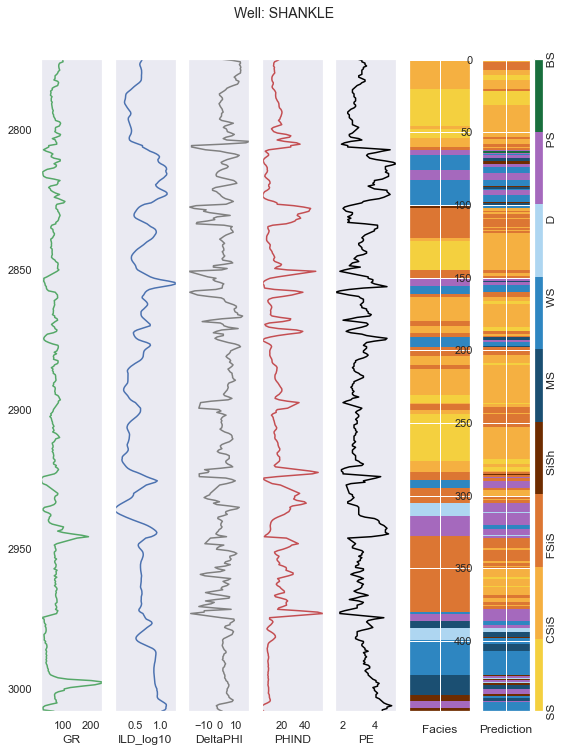

In [104]:
compare_facies_plot(blind, 'Prediction', facies_colors)


In [105]:
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf, adjacent_facies))

Optimized adjacent facies classification accuracy = 0.90


## Step 13 Algorithm 02 :  Logistic Regression For multiclass Classifiaction

In [106]:
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import pickle 
import seaborn as sns

In [107]:
training_data.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesLabels
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000,FSiS
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979,FSiS
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957,FSiS
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936,FSiS
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915,FSiS


In [108]:
training_data.columns

Index(['Facies', 'Formation', 'Well Name', 'Depth', 'GR', 'ILD_log10',
       'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS', 'FaciesLabels'],
      dtype='object')

In [109]:
outlier_check = training_data[['GR', 'ILD_log10','DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS' , 'Facies']]

In [110]:
outlier_check.head()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies
0,77.45,0.664,9.9,11.915,4.6,1,1.000,3
1,78.26,0.661,14.2,12.565,4.1,1,0.979,3
2,79.05,0.658,14.8,13.050,3.6,1,0.957,3
3,86.10,0.655,13.9,13.115,3.5,1,0.936,3
4,74.58,0.647,13.5,13.300,3.4,1,0.915,3


<AxesSubplot:>

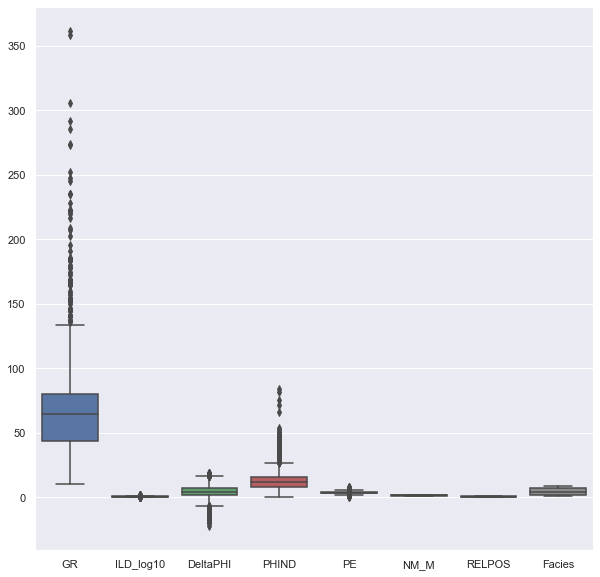

In [111]:
fig , ax = plt.subplots(figsize = (10,10))
sns.boxplot(data = outlier_check , ax = ax)

In [112]:
def outlier_removal(data):
        def outlier_limits(col):
            Q3, Q1 = col.quantile([0.75,0.25])
            IQR= Q3-Q1
            UL= Q3+1.5*IQR
            LL= Q1-1.5*IQR
            return UL, LL

        for column in data.columns:
            if data[column].dtype == 'float64':
                UL, LL= outlier_limits(data[column])
                data[column]= np.where((data[column] > UL) | (data[column] < LL),np.nan, data[column])

        return data

In [113]:
outlier_removal(outlier_check)

<ipython-input-112-5e5148b5cdc6>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column]= np.where((data[column] > UL) | (data[column] < LL),np.nan, data[column])
<ipython-input-112-5e5148b5cdc6>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column]= np.where((data[column] > UL) | (data[column] < LL),np.nan, data[column])
<ipython-input-112-5e5148b5cdc6>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies
0,77.450,0.664,9.900,11.915,4.600,1,1.000,3
1,78.260,0.661,14.200,12.565,4.100,1,0.979,3
2,79.050,0.658,14.800,13.050,3.600,1,0.957,3
3,86.100,0.655,13.900,13.115,3.500,1,0.936,3
4,74.580,0.647,13.500,13.300,3.400,1,0.915,3
...,...,...,...,...,...,...,...,...
4144,46.719,0.947,1.828,7.254,3.617,2,0.685,5
4145,44.563,0.953,2.241,8.013,3.344,2,0.677,5
4146,49.719,0.964,2.925,8.013,3.190,2,0.669,5
4147,51.469,0.965,3.083,7.708,3.152,2,0.661,5


In [114]:
outlier_check.dropna(inplace= True)

<ipython-input-114-10bd5055794d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_check.dropna(inplace= True)


In [115]:
outlier_check.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies
count,3316.000000,3316.000000,3316.000000,3316.000000,3316.000000,3316.000000,3316.000000,3316.000000
mean,62.254866,0.663203,5.105850,12.001713,3.843947,1.544029,0.526266,4.600422
std,24.045689,0.236150,4.204689,4.795259,0.732710,0.498133,0.285790,2.464686
min,13.250000,0.021189,-6.800000,0.550000,1.968000,1.000000,0.000000,1.000000
25%,43.493750,0.509000,2.000000,8.330000,3.300000,1.000000,0.282000,2.000000
50%,64.125000,0.652000,4.700000,11.602500,3.700000,2.000000,0.533000,4.000000
75%,79.032000,0.823000,7.800000,14.972375,4.365332,2.000000,0.774000,7.000000
max,133.545000,1.304000,16.286000,26.800000,6.062000,2.000000,1.000000,9.000000


<AxesSubplot:>

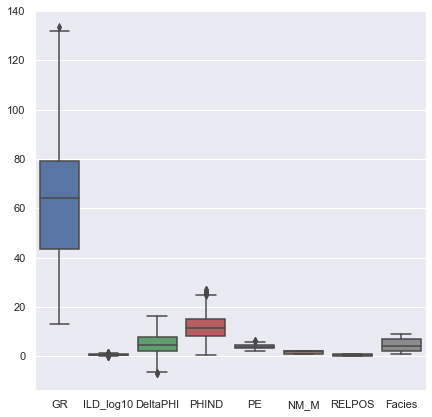

In [116]:
fig , ax = plt.subplots(figsize = (7,7))
sns.boxplot(data = outlier_check , ax = ax)

In [117]:
outlier_check.head()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies
0,77.45,0.664,9.9,11.915,4.6,1,1.000,3
1,78.26,0.661,14.2,12.565,4.1,1,0.979,3
2,79.05,0.658,14.8,13.050,3.6,1,0.957,3
3,86.10,0.655,13.9,13.115,3.5,1,0.936,3
4,74.58,0.647,13.5,13.300,3.4,1,0.915,3


In [118]:
x = outlier_check.drop(["Facies" ] , axis = 1)
y = outlier_check.Facies


In [119]:
scalar_logi = StandardScaler()

In [120]:
x_scaled = scalar_logi.fit_transform(x)

<AxesSubplot:>

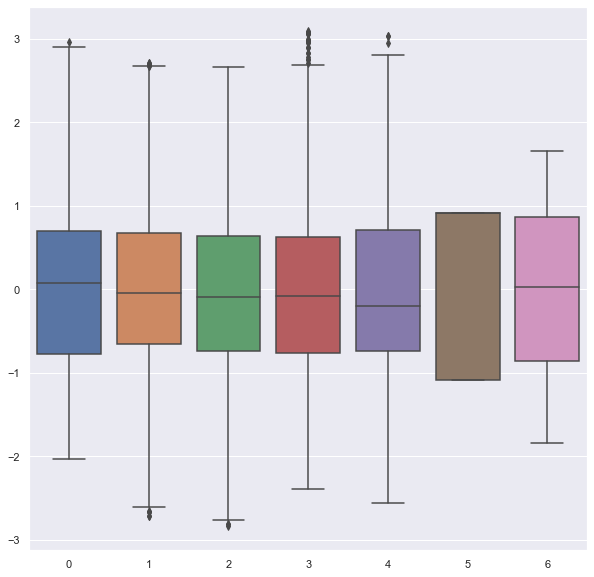

In [121]:
fig , ax = plt.subplots(figsize = (10,10))
sns.boxplot(data = pd.DataFrame(x_scaled), ax = ax )

In [122]:
x_train , x_test , y_train , y_test = train_test_split(x_scaled ,  y  , test_size = .20 , random_state   =  0 )

#### Modelling Part

In [123]:
logi1  = LogisticRegression(verbose=1 ,n_jobs=4, penalty = 'l2',solver='lbfgs' )
logi2  = LogisticRegression(verbose=1 ,n_jobs=4 ,penalty = 'l1',solver='liblinear' )
logi3  = LogisticRegression(verbose=1 ,n_jobs=4 ,penalty = 'l2',solver='liblinear' )
logi4  = LogisticRegression(verbose=1 ,n_jobs=4 ,solver='newton-cg' )
logi5  = LogisticRegression(verbose=1 ,n_jobs=4 ,solver='liblinear' )
logi6  = LogisticRegression(verbose=1 ,n_jobs=4 ,penalty = 'none',solver='sag' )


In [124]:
logi1.fit(x_train,y_train)
logi2.fit(x_train,y_train)
logi3.fit(x_train,y_train)
logi4.fit(x_train,y_train)
logi5.fit(x_train,y_train)
logi6.fit(x_train,y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.8s finished
C:\Users\CHINTAN PATEL\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\Users\CHINTAN PATEL\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


[LibLinear][LibLinear]

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.8s finished
C:\Users\CHINTAN PATEL\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


[LibLinear]max_iter reached after 1 seconds


C:\Users\CHINTAN PATEL\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    0.1s finished


LogisticRegression(n_jobs=4, penalty='none', solver='sag', verbose=1)

In [125]:
y_predi_logi1 = logi1.predict_proba(x_test)
y_predi_logi2 = logi2.predict_proba(x_test)
y_predi_logi3 = logi3.predict_proba(x_test)
y_predi_logi4 = logi4.predict_proba(x_test)
y_predi_logi5 = logi5.predict_proba(x_test)
y_predi_logi6 = logi6.predict_proba(x_test)

In [126]:
from sklearn.metrics import roc_curve , auc , roc_auc_score

In [127]:
auc_logi1 = roc_auc_score(y_test, y_predi_logi1 , multi_class="ovr")
auc_logi2 = roc_auc_score(y_test, y_predi_logi2 , multi_class="ovr")
auc_logi3 = roc_auc_score(y_test, y_predi_logi3 , multi_class="ovr")
auc_logi4 = roc_auc_score(y_test, y_predi_logi4,multi_class="ovr")
auc_logi5 = roc_auc_score(y_test, y_predi_logi5,multi_class="ovr")
auc_logi6 = roc_auc_score(y_test, y_predi_logi6,multi_class="ovr")


In [128]:
print("Area Under Curve of TPR vs FPR For Model_01 : " + str(auc_logi1))
print("Area Under Curve of TPR vs FPR For Model_02 : " + str(auc_logi2))
print("Area Under Curve of TPR vs FPR For Model_03 : " + str(auc_logi3))
print("Area Under Curve of TPR vs FPR For Model_04 : " + str(auc_logi4))
print("Area Under Curve of TPR vs FPR For Model_05 : " + str(auc_logi5))
print("Area Under Curve of TPR vs FPR For Model_06 : " + str(auc_logi6))


Area Under Curve of TPR vs FPR For Model_01 : 0.9249196959637584
Area Under Curve of TPR vs FPR For Model_02 : 0.922973793620343
Area Under Curve of TPR vs FPR For Model_03 : 0.9229371328944356
Area Under Curve of TPR vs FPR For Model_04 : 0.9249223089120784
Area Under Curve of TPR vs FPR For Model_05 : 0.9229371328944356
Area Under Curve of TPR vs FPR For Model_06 : 0.9247954563777974


Model_04 is logi_04 which has highest area under curve which indeicate best parameter for given dataset

In [129]:
model03_logi  = LogisticRegression(verbose=1 ,n_jobs=4 ,solver='newton-cg' )


In [130]:
model03_logi.fit(x_train,y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.8s finished


LogisticRegression(n_jobs=4, solver='newton-cg', verbose=1)

In [131]:
model03_logi.score(x_test,y_test)

0.5828313253012049

In [132]:
from sklearn.metrics import accuracy_score , confusion_matrix , roc_auc_score, roc_curve

In [133]:
y_predict = model03_logi.predict(x_test)

In [134]:
logi_cf = confusion_matrix(y_test,y_predict)

In [135]:
display_cm(logi_cf, facies_labels, 
           display_metrics=True,hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    13    17     1                                        31
     CSiS     4   124    22                       1               151
     FSiS     1    57    55     1                             1   115
     SiSh           1          37     1    11     2     3          55
       MS           1           7     7    27     1     5          48
       WS                 1     8     7    54     2    33         105
        D                       3     1     3     8     9          24
       PS                 1     5     3    21     1    74     4   109
       BS                       1           1           9    15    26

Precision  0.72  0.62  0.69  0.60  0.37  0.46  0.53  0.56  0.75  0.58
   Recall  0.42  0.82  0.48  0.67  0.15  0.51  0.33  0.68  0.58  0.58
       F1  0.53  0.71  0.56  0.63  0.21  0.49  0.41  0.61  0.65  0.57
      Total F1 Score for method : 0.5683303047844014


In [136]:
display_adj_cm(logi_cf, facies_labels, adjacent_facies,
               display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    30           1                                        31
     CSiS         150                             1               151
     FSiS     1         112     1                             1   115
     SiSh           1          38          11     2     3          55
       MS           1                41           1     5          48
       WS                 1     8          96                     105
        D                       3     1          20                24
       PS                 1     5     3               100         109
       BS                       1           1                24    26

Precision  0.97  0.99  0.97  0.68  0.91  0.89  0.83  0.93  0.96  0.92
   Recall  0.97  0.99  0.97  0.69  0.85  0.91  0.83  0.92  0.92  0.92
       F1  0.97  0.99  0.97  0.68  0.88  0.90  0.83  0.92  0.94  0.92
      Total F1 Score for method : 0.920277852184027


In [137]:
print('Optimized facies classification accuracy = %.2f' % accuracy(logi_cf))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(logi_cf, adjacent_facies))

Optimized facies classification accuracy = 0.58
Optimized adjacent facies classification accuracy = 0.92


#### Applying on blind dataset

In [138]:
blind

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Prediction
937,2,A1 SH,SHANKLE,2774.5,98.36,0.642,-0.1,18.685,2.9,1,1.000,3
938,2,A1 SH,SHANKLE,2775.0,97.57,0.631,7.9,16.745,3.2,1,0.984,3
939,2,A1 SH,SHANKLE,2775.5,98.41,0.615,12.8,14.105,3.2,1,0.968,2
940,2,A1 SH,SHANKLE,2776.0,85.92,0.597,13.0,13.385,3.4,1,0.952,3
941,2,A1 SH,SHANKLE,2776.5,83.16,0.592,12.3,13.345,3.4,1,0.935,3
...,...,...,...,...,...,...,...,...,...,...,...,...
1381,8,C LM,SHANKLE,3006.0,32.84,1.120,-2.2,3.455,5.1,2,0.060,6
1382,8,C LM,SHANKLE,3006.5,25.16,1.112,-1.6,2.890,4.8,2,0.045,6
1383,8,C LM,SHANKLE,3007.0,25.16,1.112,-1.6,2.890,4.8,2,0.030,6
1384,4,C LM,SHANKLE,3007.5,26.22,1.092,-0.4,3.400,4.5,2,0.030,6


In [139]:
blind_scalled = scalar_logi.transform(blind[['GR', 'ILD_log10','DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']])

In [140]:
Y_blind_predict = model03_logi.predict(blind_scalled)

In [141]:
Y_blind = blind["Facies"]

In [142]:
blind_logi_cf = confusion_matrix(Y_blind,Y_blind_predict)

In [143]:
display_cm(blind_logi_cf, facies_labels, 
           display_metrics=True,hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    45    43     1                                        89
     CSiS    10    63    16                                        89
     FSiS     1    53    61                                   2   117
     SiSh                       5           2                       7
       MS                       9     1     6     1     2          19
       WS                       8     5    46          11     1    71
        D                                   1    14     2          17
       PS                       2     5    10          22     1    40
       BS                                                           0

Precision  0.80  0.40  0.78  0.21  0.09  0.71  0.93  0.59  0.00  0.65
   Recall  0.51  0.71  0.52  0.71  0.05  0.65  0.82  0.55  0.00  0.57
       F1  0.62  0.51  0.63  0.32  0.07  0.68  0.87  0.57  0.00  0.59
      Total F1 Score for method : 0.585624514589027


<ipython-input-73-394c7a8d1693>:11: RuntimeWarning: invalid value encountered in true_divide
  recall = np.diagonal(cm)/cm.sum(axis=1).astype('float')


In [144]:
display_adj_cm(blind_logi_cf, facies_labels, adjacent_facies,
               display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    88           1                                        89
     CSiS          89                                              89
     FSiS     1         114                                   2   117
     SiSh                       5           2                       7
       MS                            16           1     2          19
       WS                       8          62                 1    71
        D                                        17                17
       PS                       2     5                33          40
       BS                                                           0

Precision  0.99  1.00  0.99  0.33  0.76  0.97  0.94  0.94  0.00  0.96
   Recall  0.99  1.00  0.97  0.71  0.84  0.87  1.00  0.82  0.00  0.94
       F1  0.99  1.00  0.98  0.45  0.80  0.92  0.97  0.88  0.00  0.95
      Total F1 Score for method : 0.9516562969523572


<ipython-input-73-394c7a8d1693>:11: RuntimeWarning: invalid value encountered in true_divide
  recall = np.diagonal(cm)/cm.sum(axis=1).astype('float')


In [185]:
blind["prediction_logi"] = Y_blind_predict

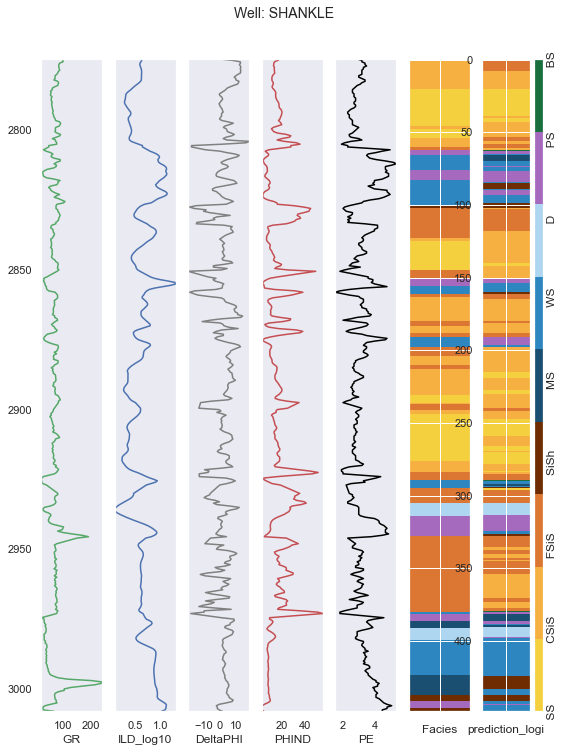

In [186]:
compare_facies_plot(blind, 'prediction_logi', facies_colors)


## Step 14 Algorithm 03 : Knn  For multiclass Classifiaction


In [145]:
from sklearn.neighbors import KNeighborsClassifier


In [146]:
vif = pd.DataFrame()
vif["vif"] = [variance_inflation_factor(x_scaled,i) for i in range(x_scaled.shape[1])]
vif["Features"] = feature_vectors.columns

#let's check the values
vif

,vif,Features
0,1.620640,GR
1,2.102730,ILD_log10
2,1.253349,DeltaPHI
3,2.350846,PHIND
4,2.038276,PE
5,2.165026,NM_M
6,1.050029,RELPOS


In [147]:
knn = KNeighborsClassifier()
knn.fit(x_train,y_train)

KNeighborsClassifier()

In [148]:
y_pred = knn.predict(x_test)

In [149]:
knn.score(x_train,y_train)

0.803921568627451

In [150]:
knn.score(x_test,y_test)

0.7033132530120482

In [151]:
param_grid = { 'algorithm' : ['ball_tree', 'kd_tree', 'brute'],
               'leaf_size' : [18,20,25,27,30,32,34],
               'n_neighbors' : [3,5,7,9,10,11,12,13]
              }

In [152]:
gridsearch = GridSearchCV(knn, param_grid,verbose=3)

In [153]:
gridsearch.fit(x_train,y_train)

Fitting 5 folds for each of 168 candidates, totalling 840 fits
[CV 1/5] END algorithm=ball_tree, leaf_size=18, n_neighbors=3; total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=18, n_neighbors=3; total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=18, n_neighbors=3; total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=18, n_neighbors=3; total time=   0.0s
[CV 5/5] END algorithm=ball_tree, leaf_size=18, n_neighbors=3; total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=18, n_neighbors=5; total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=18, n_neighbors=5; total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=18, n_neighbors=5; total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=18, n_neighbors=5; total time=   0.0s
[CV 5/5] END algorithm=ball_tree, leaf_size=18, n_neighbors=5; total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=18, n_neighbors=7; total time=   0.0s
[CV 2/5] END algorithm=ball_tree, l

[CV 2/5] END algorithm=ball_tree, leaf_size=25, n_neighbors=10; total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=25, n_neighbors=10; total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=25, n_neighbors=10; total time=   0.0s
[CV 5/5] END algorithm=ball_tree, leaf_size=25, n_neighbors=10; total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=25, n_neighbors=11; total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=25, n_neighbors=11; total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=25, n_neighbors=11; total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=25, n_neighbors=11; total time=   0.0s
[CV 5/5] END algorithm=ball_tree, leaf_size=25, n_neighbors=11; total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=25, n_neighbors=12; total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=25, n_neighbors=12; total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=25, n_neighbors=12; total time=   0.0s
[CV 

[CV 3/5] END algorithm=ball_tree, leaf_size=32, n_neighbors=3; total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=32, n_neighbors=3; total time=   0.0s
[CV 5/5] END algorithm=ball_tree, leaf_size=32, n_neighbors=3; total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=32, n_neighbors=5; total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=32, n_neighbors=5; total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=32, n_neighbors=5; total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=32, n_neighbors=5; total time=   0.0s
[CV 5/5] END algorithm=ball_tree, leaf_size=32, n_neighbors=5; total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=32, n_neighbors=7; total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=32, n_neighbors=7; total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=32, n_neighbors=7; total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=32, n_neighbors=7; total time=   0.0s
[CV 5/5] END alg

[CV 3/5] END algorithm=kd_tree, leaf_size=18, n_neighbors=10; total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=18, n_neighbors=10; total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=18, n_neighbors=10; total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=18, n_neighbors=11; total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=18, n_neighbors=11; total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=18, n_neighbors=11; total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=18, n_neighbors=11; total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=18, n_neighbors=11; total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=18, n_neighbors=12; total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=18, n_neighbors=12; total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=18, n_neighbors=12; total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=18, n_neighbors=12; total time=   0.0s
[CV 5/5] END algorithm=kd_tr

[CV 1/5] END .algorithm=kd_tree, leaf_size=27, n_neighbors=7; total time=   0.0s
[CV 2/5] END .algorithm=kd_tree, leaf_size=27, n_neighbors=7; total time=   0.0s
[CV 3/5] END .algorithm=kd_tree, leaf_size=27, n_neighbors=7; total time=   0.0s
[CV 4/5] END .algorithm=kd_tree, leaf_size=27, n_neighbors=7; total time=   0.0s
[CV 5/5] END .algorithm=kd_tree, leaf_size=27, n_neighbors=7; total time=   0.0s
[CV 1/5] END .algorithm=kd_tree, leaf_size=27, n_neighbors=9; total time=   0.0s
[CV 2/5] END .algorithm=kd_tree, leaf_size=27, n_neighbors=9; total time=   0.0s
[CV 3/5] END .algorithm=kd_tree, leaf_size=27, n_neighbors=9; total time=   0.0s
[CV 4/5] END .algorithm=kd_tree, leaf_size=27, n_neighbors=9; total time=   0.0s
[CV 5/5] END .algorithm=kd_tree, leaf_size=27, n_neighbors=9; total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=27, n_neighbors=10; total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=27, n_neighbors=10; total time=   0.0s
[CV 3/5] END algorithm=kd_tr

[CV 5/5] END algorithm=kd_tree, leaf_size=32, n_neighbors=12; total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=32, n_neighbors=13; total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=32, n_neighbors=13; total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=32, n_neighbors=13; total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=32, n_neighbors=13; total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=32, n_neighbors=13; total time=   0.0s
[CV 1/5] END .algorithm=kd_tree, leaf_size=34, n_neighbors=3; total time=   0.0s
[CV 2/5] END .algorithm=kd_tree, leaf_size=34, n_neighbors=3; total time=   0.0s
[CV 3/5] END .algorithm=kd_tree, leaf_size=34, n_neighbors=3; total time=   0.0s
[CV 4/5] END .algorithm=kd_tree, leaf_size=34, n_neighbors=3; total time=   0.0s
[CV 5/5] END .algorithm=kd_tree, leaf_size=34, n_neighbors=3; total time=   0.0s
[CV 1/5] END .algorithm=kd_tree, leaf_size=34, n_neighbors=5; total time=   0.0s
[CV 2/5] END .algorithm=kd_t

[CV 4/5] END ...algorithm=brute, leaf_size=20, n_neighbors=9; total time=   0.0s
[CV 5/5] END ...algorithm=brute, leaf_size=20, n_neighbors=9; total time=   0.0s
[CV 1/5] END ..algorithm=brute, leaf_size=20, n_neighbors=10; total time=   0.0s
[CV 2/5] END ..algorithm=brute, leaf_size=20, n_neighbors=10; total time=   0.0s
[CV 3/5] END ..algorithm=brute, leaf_size=20, n_neighbors=10; total time=   0.0s
[CV 4/5] END ..algorithm=brute, leaf_size=20, n_neighbors=10; total time=   0.0s
[CV 5/5] END ..algorithm=brute, leaf_size=20, n_neighbors=10; total time=   0.0s
[CV 1/5] END ..algorithm=brute, leaf_size=20, n_neighbors=11; total time=   0.0s
[CV 2/5] END ..algorithm=brute, leaf_size=20, n_neighbors=11; total time=   0.0s
[CV 3/5] END ..algorithm=brute, leaf_size=20, n_neighbors=11; total time=   0.0s
[CV 4/5] END ..algorithm=brute, leaf_size=20, n_neighbors=11; total time=   0.0s
[CV 5/5] END ..algorithm=brute, leaf_size=20, n_neighbors=11; total time=   0.0s
[CV 1/5] END ..algorithm=bru

[CV 5/5] END ...algorithm=brute, leaf_size=30, n_neighbors=3; total time=   0.0s
[CV 1/5] END ...algorithm=brute, leaf_size=30, n_neighbors=5; total time=   0.0s
[CV 2/5] END ...algorithm=brute, leaf_size=30, n_neighbors=5; total time=   0.0s
[CV 3/5] END ...algorithm=brute, leaf_size=30, n_neighbors=5; total time=   0.0s
[CV 4/5] END ...algorithm=brute, leaf_size=30, n_neighbors=5; total time=   0.0s
[CV 5/5] END ...algorithm=brute, leaf_size=30, n_neighbors=5; total time=   0.0s
[CV 1/5] END ...algorithm=brute, leaf_size=30, n_neighbors=7; total time=   0.0s
[CV 2/5] END ...algorithm=brute, leaf_size=30, n_neighbors=7; total time=   0.0s
[CV 3/5] END ...algorithm=brute, leaf_size=30, n_neighbors=7; total time=   0.0s
[CV 4/5] END ...algorithm=brute, leaf_size=30, n_neighbors=7; total time=   0.0s
[CV 5/5] END ...algorithm=brute, leaf_size=30, n_neighbors=7; total time=   0.0s
[CV 1/5] END ...algorithm=brute, leaf_size=30, n_neighbors=9; total time=   0.0s
[CV 2/5] END ...algorithm=br

[CV 2/5] END ..algorithm=brute, leaf_size=34, n_neighbors=11; total time=   0.0s
[CV 3/5] END ..algorithm=brute, leaf_size=34, n_neighbors=11; total time=   0.0s
[CV 4/5] END ..algorithm=brute, leaf_size=34, n_neighbors=11; total time=   0.0s
[CV 5/5] END ..algorithm=brute, leaf_size=34, n_neighbors=11; total time=   0.0s
[CV 1/5] END ..algorithm=brute, leaf_size=34, n_neighbors=12; total time=   0.0s
[CV 2/5] END ..algorithm=brute, leaf_size=34, n_neighbors=12; total time=   0.0s
[CV 3/5] END ..algorithm=brute, leaf_size=34, n_neighbors=12; total time=   0.0s
[CV 4/5] END ..algorithm=brute, leaf_size=34, n_neighbors=12; total time=   0.0s
[CV 5/5] END ..algorithm=brute, leaf_size=34, n_neighbors=12; total time=   0.0s
[CV 1/5] END ..algorithm=brute, leaf_size=34, n_neighbors=13; total time=   0.0s
[CV 2/5] END ..algorithm=brute, leaf_size=34, n_neighbors=13; total time=   0.0s
[CV 3/5] END ..algorithm=brute, leaf_size=34, n_neighbors=13; total time=   0.0s
[CV 4/5] END ..algorithm=bru

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [18, 20, 25, 27, 30, 32, 34],
                         'n_neighbors': [3, 5, 7, 9, 10, 11, 12, 13]},
             verbose=3)

In [154]:
# let's see the  best parameters according to gridsearch
gridsearch.best_params_ 


{'algorithm': 'ball_tree', 'leaf_size': 18, 'n_neighbors': 3}

In [161]:
# we will use the best parameters in our k-NN algorithm and check if accuracy is increasing.
model04_knn = KNeighborsClassifier(algorithm ='ball_tree', leaf_size = 18, n_neighbors = 3)

In [162]:
model04_knn.fit(x_train,y_train)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=18, n_neighbors=3)

In [163]:
knn.score(x_train,y_train)

0.803921568627451

In [164]:
knn.score(x_test,y_test)

0.7033132530120482

####  Selecting K values by cheking accuracy 

In [165]:
from sklearn.model_selection import KFold


In [166]:
#k-fold cross validation 
kfold = KFold(n_splits=12,random_state= 42 , shuffle = True)
kfold.get_n_splits(x_scaled)

12

In [167]:
from statistics import mean
knn = KNeighborsClassifier(algorithm = 'ball_tree', leaf_size =18, n_neighbors =11)
cnt =0
count=[]
train_score =[]
test_score = []

#here kflod.split contain array where index are stored into array of lists ...which directly passed to dataframe or series
for train_index,test_index in kfold.split(x_scaled):
    X_train, X_test = x_scaled[train_index], x_scaled[test_index] # our scaled data is an array so it can work on x[value]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index] # y is a dataframe so we have to use "iloc" to retreive data
    knn.fit(X_train,y_train)
    train_score_ = knn.score(X_train,y_train)
    test_score_ =  knn.score(X_test,y_test)
    cnt+=1
    count.append(cnt)
    train_score.append(train_score_)
    test_score.append(test_score_)
    
    print("for k = ", cnt)
    print("train_score is :  ", train_score_, "and test score is :  ", test_score_)
print("************************************************")
print("************************************************")
print("Average train score is :  ", mean(train_score))
print("Average test score is :  ", mean(test_score))

for k =  1
train_score is :   0.7341230667982889 and test score is :   0.6859205776173285
for k =  2
train_score is :   0.7354392892398816 and test score is :   0.6389891696750902
for k =  3
train_score is :   0.7341230667982889 and test score is :   0.6714801444043321
for k =  4
train_score is :   0.7305034550839091 and test score is :   0.6967509025270758
for k =  5
train_score is :   0.7322368421052632 and test score is :   0.6630434782608695
for k =  6
train_score is :   0.7348684210526316 and test score is :   0.6521739130434783
for k =  7
train_score is :   0.7335526315789473 and test score is :   0.6739130434782609
for k =  8
train_score is :   0.7398026315789473 and test score is :   0.6304347826086957
for k =  9
train_score is :   0.7315789473684211 and test score is :   0.6485507246376812
for k =  10
train_score is :   0.7345394736842106 and test score is :   0.644927536231884
for k =  11
train_score is :   0.7335526315789473 and test score is :   0.6811594202898551
for k =  

([<matplotlib.axis.YTick at 0x167c59852b0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

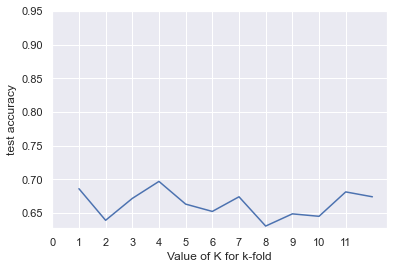

In [168]:
# let's plot the test_accuracy with the value of k in k-fold

plt.plot(count,test_score)
plt.xlabel('Value of K for k-fold')
plt.ylabel('test accuracy')
plt.xticks(np.arange(0, 12, 1)) 
plt.yticks(np.arange(0.65, 1, 0.05)) 

"Optimized k value is k = 4 "

In [169]:
x_train , x_test , y_train , y_test = train_test_split(x_scaled ,  y  , test_size = .20 , random_state   =  0 )

In [170]:
model04_knn = KNeighborsClassifier(algorithm ='ball_tree', leaf_size = 18, n_neighbors = 4)

In [171]:
model04_knn.fit(x_train,y_train)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=18, n_neighbors=4)

In [172]:
knn.score(x_test,y_test)

0.7484939759036144

In [173]:
y_predict_knn = model04_knn.predict(x_test)

In [174]:
knn_cf = confusion_matrix(y_test,y_predict_knn)

In [175]:
display_cm(knn_cf, facies_labels, 
           display_metrics=True,hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    26     4     1                                        31
     CSiS     2   128    20           1                           151
     FSiS          41    74                                       115
     SiSh     1           2    44     3     2           3          55
       MS     1                 4    29     9           4     1    48
       WS                 1     8    12    72          12         105
        D                       2     2     2    14     4          24
       PS           1           3     9    18     1    74     3   109
       BS                       1           2                23    26

Precision  0.87  0.74  0.76  0.71  0.52  0.69  0.93  0.76  0.85  0.74
   Recall  0.84  0.85  0.64  0.80  0.60  0.69  0.58  0.68  0.88  0.73
       F1  0.85  0.79  0.69  0.75  0.56  0.69  0.72  0.72  0.87  0.73
      Total F1 Score for method : 0.7281899246553329


In [176]:
display_adj_cm(knn_cf, facies_labels, adjacent_facies,
               display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    30           1                                        31
     CSiS         150                 1                           151
     FSiS               115                                       115
     SiSh     1           2    47           2           3          55
       MS     1                      42                 4     1    48
       WS                 1     8          96                     105
        D                       2     2          20                24
       PS           1           3     9                96         109
       BS                       1           2                23    26

Precision  0.94  0.99  0.97  0.77  0.78  0.96  1.00  0.93  0.96  0.94
   Recall  0.97  0.99  1.00  0.85  0.88  0.91  0.83  0.88  0.88  0.93
       F1  0.95  0.99  0.98  0.81  0.82  0.94  0.91  0.91  0.92  0.93
      Total F1 Score for method : 0.9329111463928255


In [177]:
blind_scalled = scalar_logi.transform(blind[['GR', 'ILD_log10','DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']])

In [178]:
y_predict_blind_knn = model04_knn.predict(blind_scalled)

In [180]:
knn_cf_blind = confusion_matrix(Y_blind,y_predict_blind_knn)

In [181]:
display_cm(knn_cf_blind, facies_labels, 
           display_metrics=True,hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    27    59     3                                        89
     CSiS    14    70     5                                        89
     FSiS          69    48                                       117
     SiSh                       1     1     4           1           7
       MS                       8     2     4     1     4          19
       WS                 2     6    16    37          10          71
        D                             4     1    11     1          17
       PS           1           2     2    17     3    14     1    40
       BS                                                           0

Precision  0.66  0.35  0.83  0.06  0.08  0.59  0.73  0.47  0.00  0.58
   Recall  0.30  0.79  0.41  0.14  0.11  0.52  0.65  0.35  0.00  0.47
       F1  0.42  0.49  0.55  0.08  0.09  0.55  0.69  0.40  0.00  0.48
      Total F1 Score for method : 0.4757751405021458


<ipython-input-73-394c7a8d1693>:11: RuntimeWarning: invalid value encountered in true_divide
  recall = np.diagonal(cm)/cm.sum(axis=1).astype('float')


In [182]:
display_adj_cm(knn_cf_blind, facies_labels, adjacent_facies,
               display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    86           3                                        89
     CSiS          89                                              89
     FSiS               117                                       117
     SiSh                       2           4           1           7
       MS                            14           1     4          19
       WS                 2     6          63                      71
        D                             4          13                17
       PS           1           2     2                35          40
       BS                                                           0

Precision  1.00  0.99  0.96  0.20  0.70  0.94  0.93  0.88  0.00  0.94
   Recall  0.97  1.00  1.00  0.29  0.74  0.89  0.76  0.88  0.00  0.93
       F1  0.98  0.99  0.98  0.24  0.72  0.91  0.84  0.88  0.00  0.94
      Total F1 Score for method : 0.9351929091376638


<ipython-input-73-394c7a8d1693>:9: RuntimeWarning: invalid value encountered in true_divide
  precision = np.diagonal(cm)/cm.sum(axis=0).astype('float')
<ipython-input-73-394c7a8d1693>:11: RuntimeWarning: invalid value encountered in true_divide
  recall = np.diagonal(cm)/cm.sum(axis=1).astype('float')


In [183]:
blind["prediction_knn"] = y_predict_blind_knn

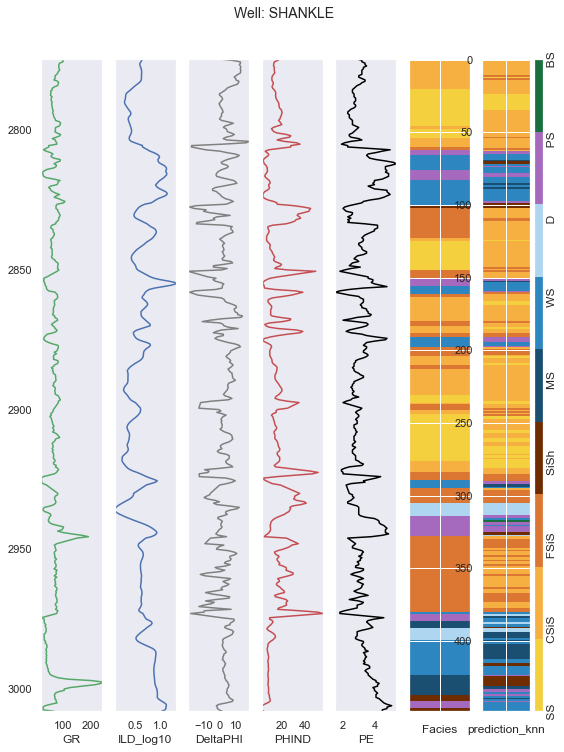

In [184]:
compare_facies_plot(blind, 'prediction_knn', facies_colors)
